
# Keras, Regression, and CNNs

<ul>
    <li>Removing the fully-connected softmax classifier layer typically used for classification</li>
<li>Replacing it with a fully-connected layer with a single node along with a linear activation function.</li>
<li>Training the model with a continuous value prediction loss function such as mean squared error, mean absolute error, mean absolute percentage error, etc.</li>
</ul>


<a href="https://github.com/emanhamed/Houses-dataset" target="_blank">
https://github.com/emanhamed/Houses-dataset
</a>
<br>
<a href="https://arxiv.org/pdf/1609.08399.pdf" target="_blank">
https://arxiv.org/pdf/1609.08399.pdf
</a>
    
</p>

In [1]:
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import os
import glob
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

In [3]:
inputPath = "D:/college-lessons/MA/FIU/AI-workshop/dataset/Houses-dataset-master/Houses Dataset/HousesInfo.txt"
datasetPath = "D:/college-lessons/MA/FIU/AI-workshop/dataset/Houses-dataset-master/Houses Dataset"

In [5]:
cols = ["bedrooms", "bathrooms", "area", "zipcode", "price"]
df = pd.read_csv(inputPath, sep=" ", header=None, names=cols)


zipcodes, counts = np.unique(df["zipcode"], return_counts=True)

# loop over each of the unique zip codes and their corresponding
# count
for (zipcode, count) in zip(zipcodes, counts):
    # the zip code counts for our housing dataset is *extremely*
    # unbalanced (some only having 1 or 2 houses per zip code)
    # so let's sanitize our data by removing any houses with less
    # than 25 houses per zip code
    if count < 25:
        idxs = df[df["zipcode"] == zipcode].index
        df.drop(idxs, inplace=True)

In [6]:
# initialize our images array (i.e., the house images themselves)
images = []

# loop over the indexes of the houses
for i in df.index.values:
    # find the four images for the house and sort the file paths,
    # ensuring the four are always in the *same order*
    basePath = os.path.sep.join([datasetPath, "{}_*".format(i + 1)])
    housePaths = sorted(list(glob.glob(basePath)))
    # initialize our list of input images along with the output image
    # after *combining* the four input images
    inputImages = []
    outputImage = np.zeros((64, 64, 3), dtype="uint8")

    # loop over the input house paths
    for housePath in housePaths:
        # load the input image, resize it to be 32 32, and then
        # update the list of input images
        image = cv2.imread(housePath)
        image = cv2.resize(image, (32, 32))
        inputImages.append(image)

    # tile the four input images in the output image such the first
    # image goes in the top-right corner, the second image in the
    # top-left corner, the third image in the bottom-right corner,
    # and the final image in the bottom-left corner
    outputImage[0:32, 0:32] = inputImages[0]
    outputImage[0:32, 32:64] = inputImages[1]
    outputImage[32:64, 32:64] = inputImages[2]
    outputImage[32:64, 0:32] = inputImages[3]

    # add the tiled image to our set of images the network will be
    # trained on
    images.append(outputImage)
images = np.array(images)

In [7]:
images.shape

(362, 64, 64, 3)

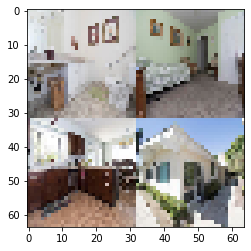

In [10]:
plt.imshow(images[45][...,::-1])

In [11]:
images = images / 255.0

In [12]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
split = train_test_split(df, images, test_size=0.25, random_state=42)
(trainAttrX, testAttrX, trainImagesX, testImagesX) = split

In [13]:
# find the largest house price in the training set and use it to
# scale our house prices to the range [0, 1] (will lead to better
# training and convergence)
maxPrice = trainAttrX["price"].max()
trainY = trainAttrX["price"] / maxPrice
testY = testAttrX["price"] / maxPrice

In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dense, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
width, height, depth = 64, 64, 3
filters=(16, 32, 64)
# initialize the input shape and channel dimension, assuming
# TensorFlow/channels-last ordering
inputShape = (height, width, depth)
chanDim = -1

# define the model input
inputs = Input(shape=inputShape)

# loop over the number of filters
for (i, f) in enumerate(filters):
    # if this is the first CONV layer then set the input
    # appropriately
    if i == 0:
        x = inputs

    # CONV => RELU => BN => POOL
    x = Conv2D(f, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
# flatten the volume, then FC => RELU => BN => DROPOUT
x = Flatten()(x)
x = Dense(16)(x)
x = Activation("relu")(x)
x = BatchNormalization(axis=chanDim)(x)
x = Dropout(0.5)(x)

# apply another FC layer, this one to match the number of nodes
# coming out of the MLP
x = Dense(4)(x)
x = Activation("relu")(x)


x = Dense(1, activation="linear")(x)

# construct the CNN
model = Model(inputs, x)

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 16)        448       
_________________________________________________________________
activation (Activation)      (None, 64, 64, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0     

In [16]:
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)

In [17]:
model.fit(trainImagesX, trainY, validation_data=(testImagesX, testY), 
          epochs=200, batch_size=8)

Epoch 1/200
34/34 [==============================] - 4s 47ms/step - loss: 2041.0808 - val_loss: 73.9914
Epoch 2/200
34/34 [==============================] - 0s 12ms/step - loss: 1002.9117 - val_loss: 650.1738
Epoch 3/200
34/34 [==============================] - 0s 11ms/step - loss: 772.6211 - val_loss: 696.2377
Epoch 4/200
34/34 [==============================] - 0s 11ms/step - loss: 754.9536 - val_loss: 200.4412
Epoch 5/200
34/34 [==============================] - 0s 11ms/step - loss: 658.7330 - val_loss: 757.4846
Epoch 6/200
34/34 [==============================] - 0s 12ms/step - loss: 447.6073 - val_loss: 1515.0216
Epoch 7/200
34/34 [==============================] - 0s 12ms/step - loss: 429.2026 - val_loss: 2535.4543
Epoch 8/200
34/34 [==============================] - 0s 11ms/step - loss: 357.0591 - val_loss: 2401.9583
Epoch 9/200
34/34 [==============================] - 0s 11ms/step - loss: 314.2249 - val_loss: 3598.0027
Epoch 10/200
34/34 [==============================] - 0s 11

Epoch 80/200
34/34 [==============================] - 0s 11ms/step - loss: 56.8168 - val_loss: 63.8746
Epoch 81/200
34/34 [==============================] - 0s 12ms/step - loss: 50.3379 - val_loss: 60.9408
Epoch 82/200
34/34 [==============================] - 0s 11ms/step - loss: 49.3628 - val_loss: 67.4960
Epoch 83/200
34/34 [==============================] - 0s 12ms/step - loss: 43.2858 - val_loss: 59.8578
Epoch 84/200
34/34 [==============================] - 0s 11ms/step - loss: 50.9949 - val_loss: 56.5360
Epoch 85/200
34/34 [==============================] - 0s 11ms/step - loss: 43.2919 - val_loss: 60.0848
Epoch 86/200
34/34 [==============================] - 0s 11ms/step - loss: 46.0601 - val_loss: 71.7395
Epoch 87/200
34/34 [==============================] - 0s 12ms/step - loss: 46.0301 - val_loss: 107.7499
Epoch 88/200
34/34 [==============================] - 0s 13ms/step - loss: 47.2349 - val_loss: 84.9163
Epoch 89/200
34/34 [==============================] - 0s 11ms/step - los

Epoch 159/200
34/34 [==============================] - 0s 12ms/step - loss: 37.3452 - val_loss: 53.7762
Epoch 160/200
34/34 [==============================] - 0s 11ms/step - loss: 34.6866 - val_loss: 54.6261
Epoch 161/200
34/34 [==============================] - 0s 11ms/step - loss: 35.3983 - val_loss: 51.2848
Epoch 162/200
34/34 [==============================] - 0s 11ms/step - loss: 36.4076 - val_loss: 67.4171
Epoch 163/200
34/34 [==============================] - 0s 11ms/step - loss: 38.5778 - val_loss: 65.1593
Epoch 164/200
34/34 [==============================] - 0s 11ms/step - loss: 36.8800 - val_loss: 54.3195
Epoch 165/200
34/34 [==============================] - 0s 11ms/step - loss: 36.8591 - val_loss: 54.9368
Epoch 166/200
34/34 [==============================] - 0s 11ms/step - loss: 41.2096 - val_loss: 54.6310
Epoch 167/200
34/34 [==============================] - 0s 11ms/step - loss: 35.4443 - val_loss: 72.8130
Epoch 168/200
34/34 [==============================] - 0s 12ms/s

## reference
https://www.pyimagesearch.com/2019/01/28/keras-regression-and-cnns/

## Contact me

### LinkedIn Account
https://www.linkedin.com/in/mohammed-behjoo-446098b7/


### YouTube Channel
https://www.youtube.com/channel/UCudI0gvPh-YbiY2zLM7im-w


### GitHub
https://github.com/mohammedbehjoo